In [1]:
import geopandas as gpd
import os
import zipfile as zf
import geopandas
from shapely.geometry import shape
import gzip 
import urllib.request
import xarray as xr
import io
import shapefile
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [4]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools
import warnings
import statsmodels.api as sm
import statsmodels

In [5]:
from meteostat import Point, Daily

ImportError: cannot import name 'Point' from 'meteostat' (C:\Users\catti\anaconda3\lib\site-packages\meteostat\__init__.py)

In [ ]:
Daily.help.

In [ ]:
df = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [ ]:
df

In [ ]:
df = df.reset_index()
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df['time'])
df = df.sort_index()
df =  df.drop(["time","index","gdp"], axis =1)

In [ ]:
df

In [ ]:
892*0.75

In [ ]:
df

In [ ]:
train,test = df[1:669], df[669:] 

In [ ]:
train

Scaling dataset

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
min_max_scaler = MinMaxScaler()
train[["timeMin", "timeMax"]] = min_max_scaler.fit_transform(train[["timeMin", "timeMax"]])

In [ ]:
train

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 50
n_future = 1
n_features = 2

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ())#None.
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ()) #THIS IS TO GET RID OF :WARNING:tensorflow:10 out of the last 11 calls to <function train_step at 0x7f4825f6d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different ecc
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [ ]:
pred_e1d1

In [ ]:
pred_e2d2

Trying to rescale it back:

In [ ]:
pred_e1d1

Do all the rest for the model  check, plot ecc :(

we can also do it with gdp??! :3

In [ ]:
df1 = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [ ]:
df1 = df1.reset_index()
df1['time'] = pd.to_datetime(df1['time'])
df1 = df1.set_index(df1['time'])
df1 = df1.sort_index()
df1 =  df1.drop(["time","index"], axis =1)

In [ ]:
train1,test1 = df1[1:669], df1[669:] 

In [ ]:
train1

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
min_max_scaler = MinMaxScaler()
train1[["timeMin", "timeMax","gdp"]] = min_max_scaler.fit_transform(train1[["timeMin", "timeMax","gdp"]])

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 50
n_future = 1
n_features = 3

In [ ]:
X_train, y_train = split_series(train1.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test1.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ())#None.
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#padded_shapes = ([618], ()) #THIS IS TO GET RID OF :WARNING:tensorflow:10 out of the last 11 calls to <function train_step at 0x7f4825f6d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different ecc
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [ ]:
pred_e1d1

In [ ]:
pred_e2d2

ANOTHER MODEL: https://github.com/imkhoa99/Time-Series-Analysis-and-Weather-Forecast-/blob/master/Time_Series_Project.ipynb

In [9]:
df2 = pd.read_pickle("GDP_temperature_anomalies_1947_USA.pkl")

In [10]:
df2 = df2.reset_index()
df2['time'] = pd.to_datetime(df2['time'])
df2 = df2.set_index(df2['time'])
df2 = df2.sort_index()
df2 =  df2.drop(["time","index","gdp"], axis =1)

In [11]:
df2

,timeMin,timeMax
time,,
1947-01-15,-6.66,4.33
1947-02-15,-3.48,3.51
1947-03-15,-3.64,4.59
1947-04-15,-1.90,1.61
1947-05-15,-2.55,2.46
...,...,...
2020-12-15,-0.27,5.58
2021-01-15,0.48,7.10
2021-02-15,-4.14,1.27


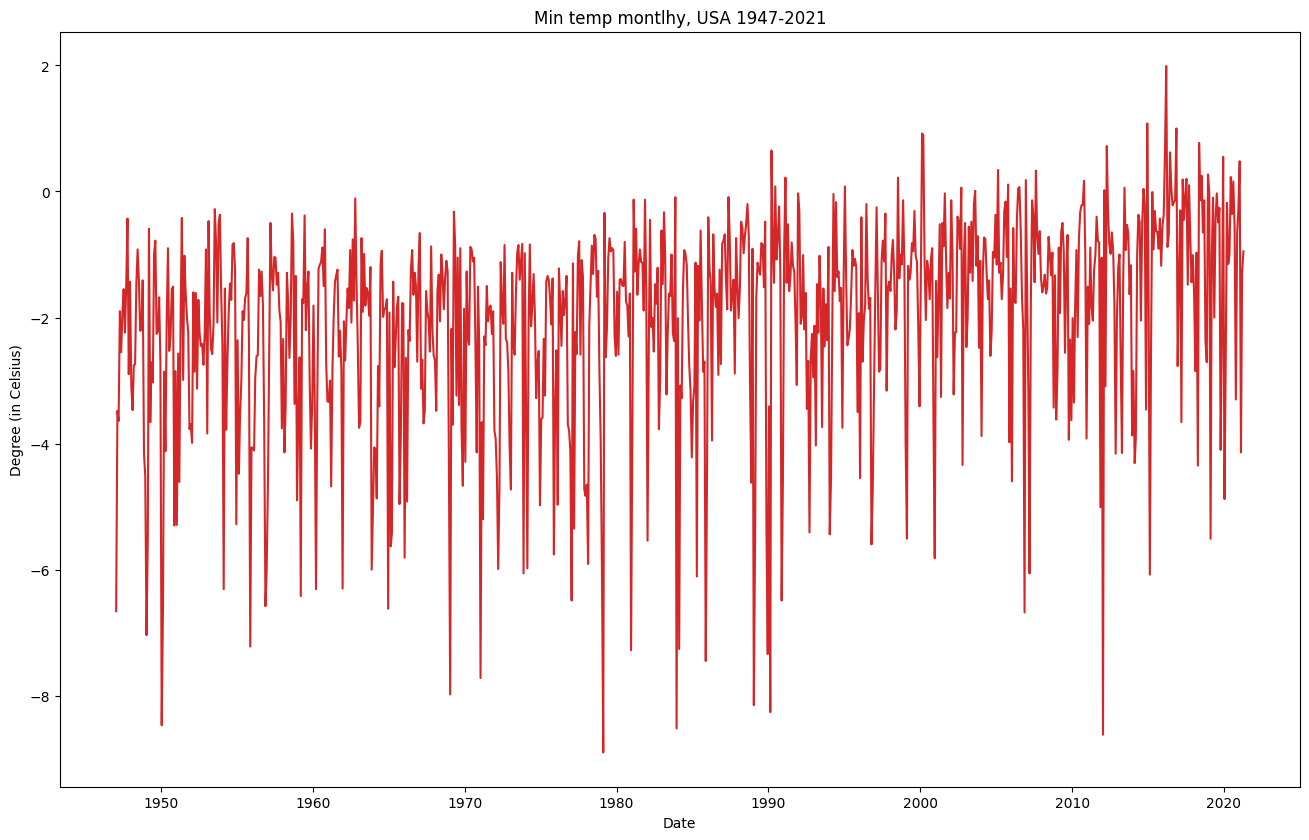

In [8]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMin, color='tab:red')
plt.gca().set(title="Min temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

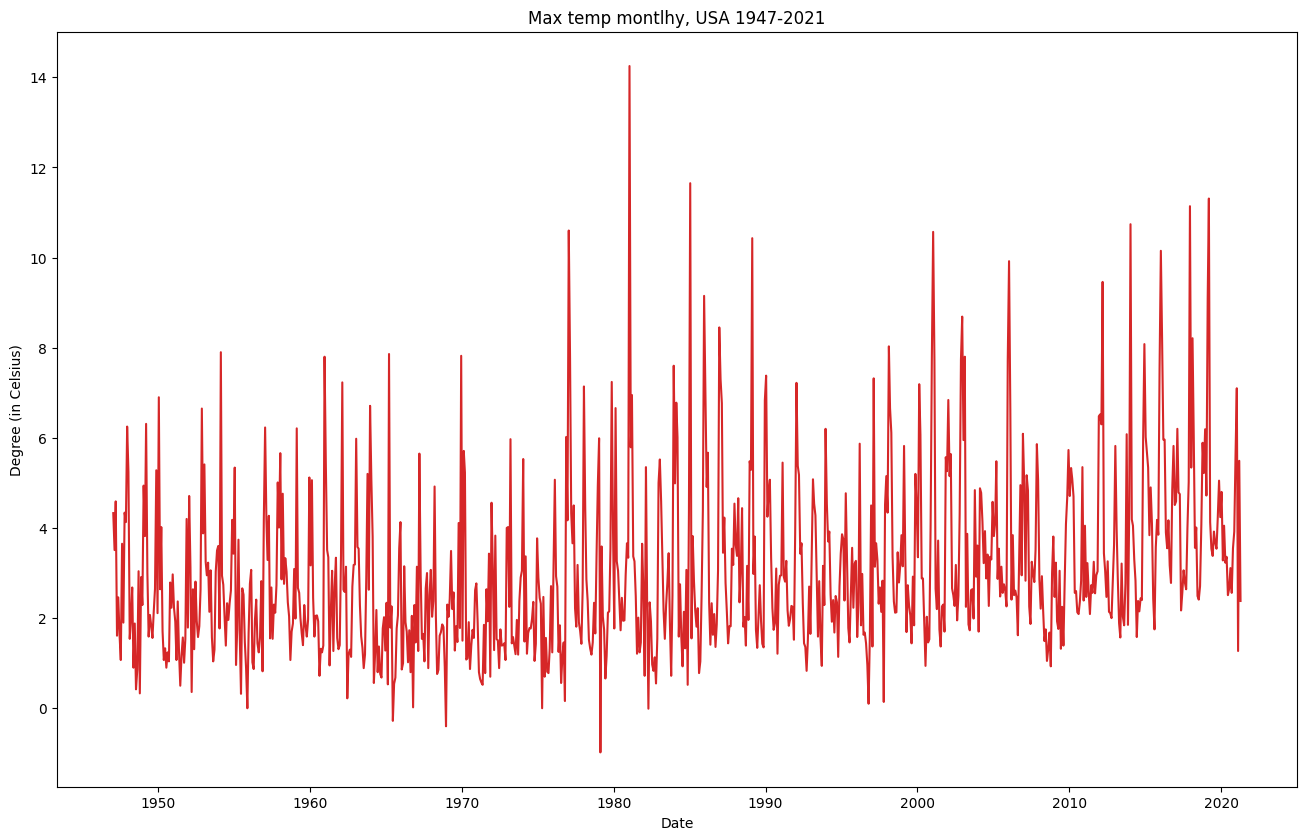

In [9]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df2.index, df2.timeMax, color='tab:red')
plt.gca().set(title="Max temp montlhy, USA 1947-2021", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

The moving average is mostly used with time series data to capture the short-term fluctuations while focusing on longer trends.

<AxesSubplot:xlabel='time'>

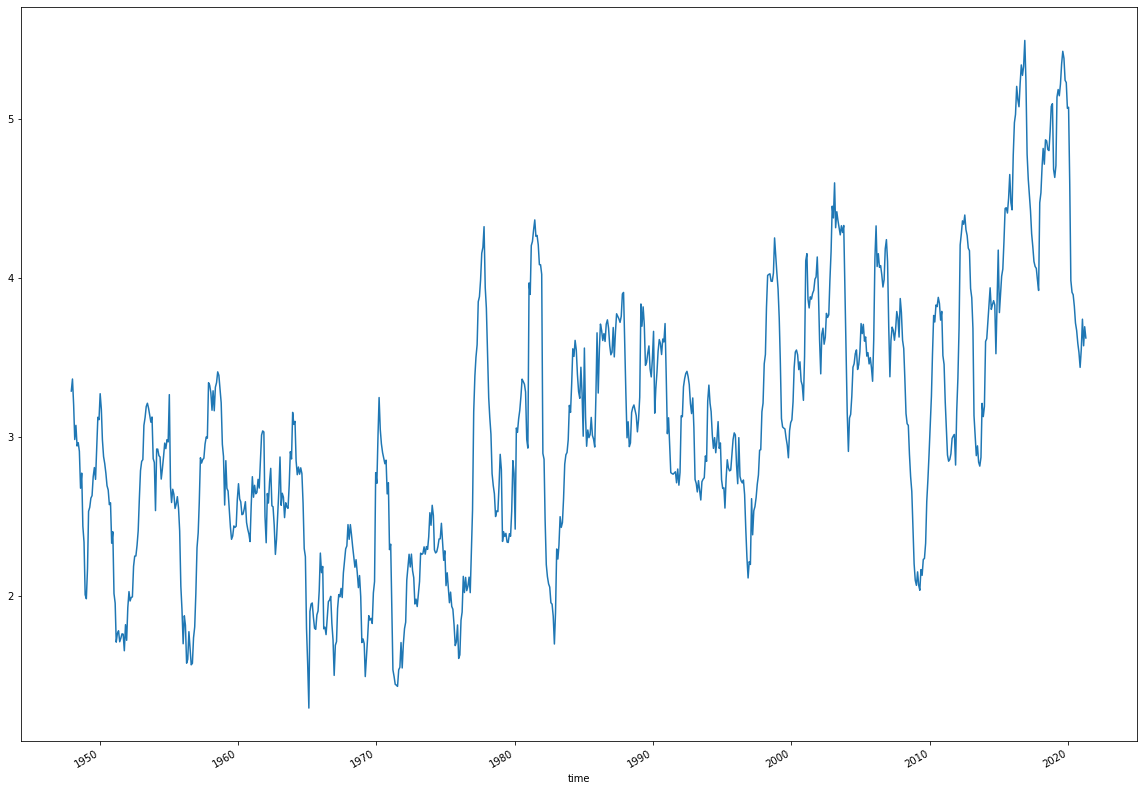

In [21]:
# Apply the Moving Average function by a subset of size 12 months to timeMax.
temp_df_mean = df2.timeMax.rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

<AxesSubplot:xlabel='time'>

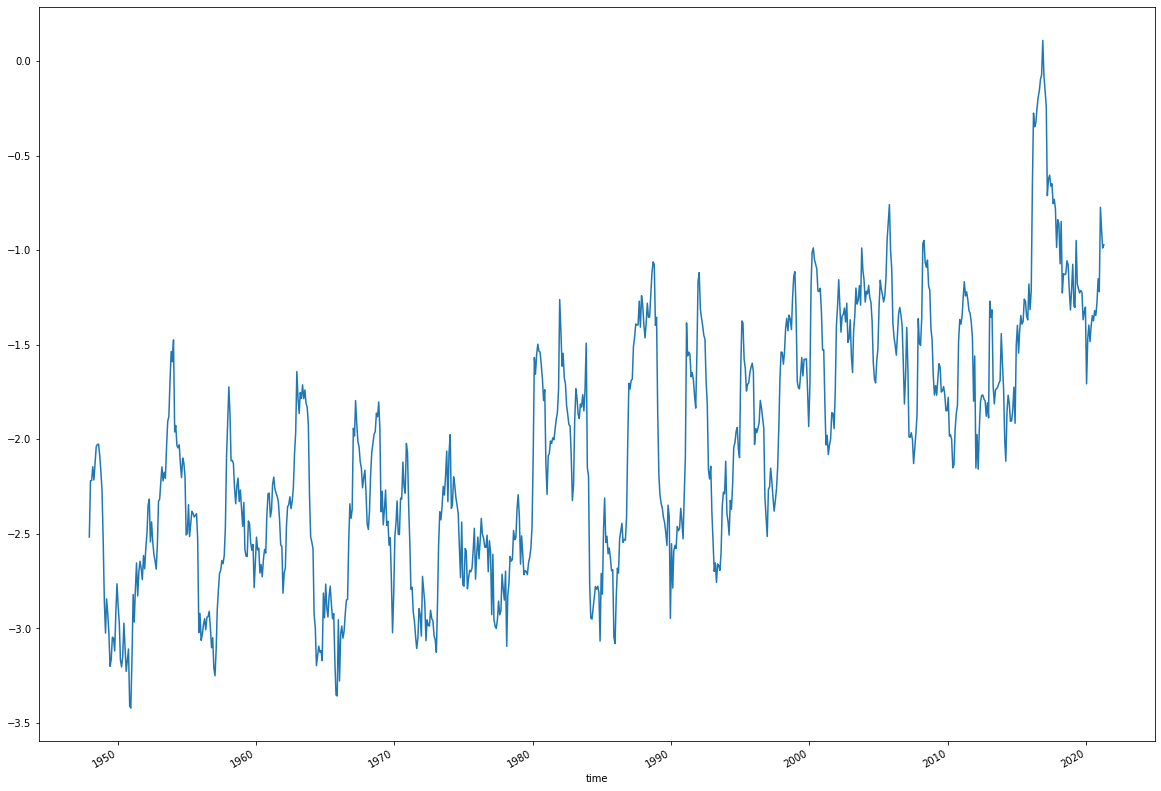

In [11]:

# Apply the Moving Average function by a subset of size 12 months to timeMin.
temp_df_mean = df2.timeMin.rolling(window=12).mean()
temp_df_mean.plot(figsize=(20,15))

is there a trend????

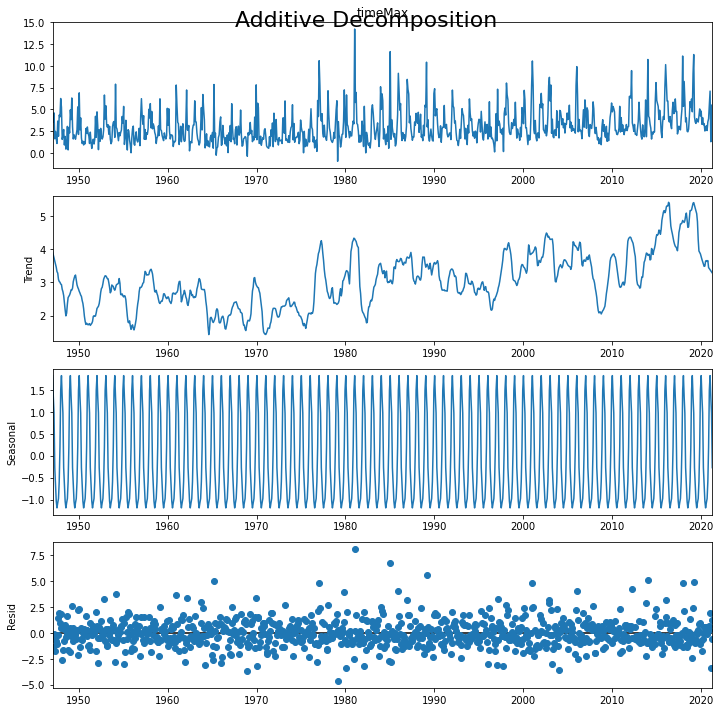

In [111]:
#FOR time MAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMax, model='additive', extrapolate_trend='freq', freq=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [ ]:
#FOR time MIN
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df2.timeMin, model='additive', extrapolate_trend='freq', freq=60)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

FOR temp MAX: 

In [24]:
predicted_df = df2["timeMax"].to_frame().shift(1).rename(columns = {"timeMax": "MAxpredicted" })
actual_df = df2["timeMax"].to_frame().rename(columns = {"timeMax": "Maxactual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(14)

,Maxactual,MAxpredicted
time,,
1947-02-15,3.51,4.33
1947-03-15,4.59,3.51
1947-04-15,1.61,4.59
1947-05-15,2.46,1.61
1947-06-15,1.63,2.46
1947-07-15,1.07,1.63
1947-08-15,3.65,1.07
1947-09-15,1.90,3.65
1947-10-15,4.34,1.90


In [25]:
one_step_df1 =one_step_df.dropna()

In [26]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df1.Maxactual, one_step_df1.MAxpredicted, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 2.0075593


In [27]:
one_step_df1 = one_step_df1.drop(["MAxpredicted"], axis =1)

In [28]:
one_step_df1

,Maxactual
time,
1947-02-15,3.51
1947-03-15,4.59
1947-04-15,1.61
1947-05-15,2.46
1947-06-15,1.63
...,...
2020-12-15,5.58
2021-01-15,7.10
2021-02-15,1.27


Hoooorayyyy! The RMSE is small, meaning that we can use the most basic 1-step prediction baseline model to predict the upcoming day's temperature with the average error of only 2.2 degrees Celsius. The error is acceptable, especially in the Weather Forecast field in which there are many other attributes that also affect the weather (e.g wind speed, atmospheric pressure, humidity, etc).

Another widely-used technique for time series prediction is SARIMA Model. I would like to see if it is possible to lower the prediction error (although it is already really small and totally okay to use it with small tolerance).

In [131]:
from statsmodels.tsa.stattools import adfuller
result =adfuller(one_step_df1)

print('ADF statistics: %f' % result[0])
print('pvalue: %f' % result[1])
print('Critical values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF statistics: -3.705539
pvalue: 0.004036
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


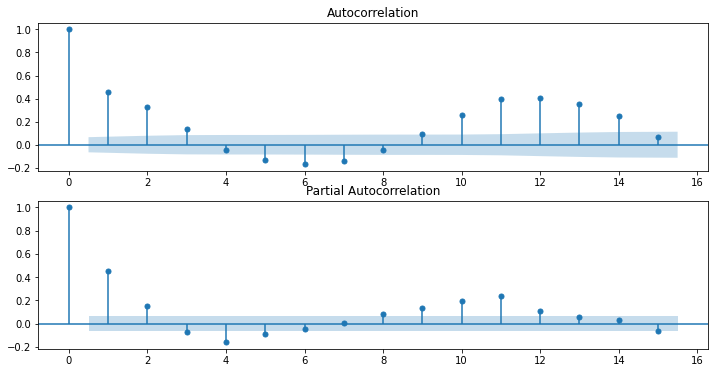

In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(2, figsize=(12,6))
ax[0]= plot_acf(one_step_df1, ax=ax[0],lags=15)
ax[1]= plot_pacf(one_step_df1, ax=ax[1],lags=15)

Let's split the data

In [132]:
test = one_step_df1[(len(one_step_df)-12):]

In [106]:
one_step_df1.iloc[-12:] = float("NAN")

Now sarima:

In [154]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [108]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df1.Maxactual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4743.093453893443
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4244.699429583881
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3750.835331168568
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3188.4345248794007
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3680.0981532654496
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3221.7370669071943
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3389.6233505553582
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3193.970680660739
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4226.2213130093605
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3976.961134672376
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3735.6014630568684
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3158.6046182360424
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3649.8706732871706
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3196.4866796827987
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3364.4104682261886
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3163.8105761880533
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3709.6498805186384
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

In [109]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}


{((1, 0, 1), (0, 1, 1, 12)): 3127.803217654527,
 ((1, 1, 1), (0, 1, 1, 12)): 3128.976312901277,
 ((1, 0, 1), (1, 1, 1, 12)): 3136.3104030521936,
 ((1, 1, 1), (1, 1, 1, 12)): 3140.7602002740823,
 ((0, 1, 1), (0, 1, 1, 12)): 3141.9429069893113,
 ((0, 1, 1), (1, 1, 1, 12)): 3153.326690607887,
 ((1, 0, 0), (0, 1, 1, 12)): 3157.63695537537,
 ((0, 0, 1), (0, 1, 1, 12)): 3158.6046182360424,
 ((1, 0, 0), (1, 1, 1, 12)): 3163.3098003006376,
 ((0, 0, 1), (1, 1, 1, 12)): 3163.8105761880533,
 ((1, 0, 1), (1, 0, 1, 12)): 3172.8881270893935,
 ((1, 1, 1), (1, 0, 1, 12)): 3184.276188020286,
 ((0, 0, 0), (0, 1, 1, 12)): 3188.4345248794007,
 ((0, 0, 0), (1, 1, 1, 12)): 3193.970680660739,
 ((1, 0, 0), (1, 0, 1, 12)): 3194.012500315923,
 ((0, 1, 1), (1, 0, 1, 12)): 3196.225080178907,
 ((0, 0, 1), (1, 0, 1, 12)): 3196.4866796827987,
 ((0, 0, 0), (1, 0, 1, 12)): 3221.7370669071943,
 ((1, 0, 1), (1, 1, 0, 12)): 3341.018210218685,
 ((1, 1, 1), (1, 0, 0, 12)): 3342.6313173264093,
 ((1, 1, 0), (0, 1, 1, 12)): 3

In [110]:
import statsmodels.api as sm
#SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3058.5411445042273
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df1.Maxactual,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8365      0.068     12.263      0.000       0.703       0.970
ma.L1         -0.6789      0.083     -8.159      0.000      -0.842      -0.516
ma.S.L12      -1.0845      0.017    -65.646      0.000      -1.117      -1.052
sigma2         1.8948      0.077     24.685      0.000       1.744       2.045


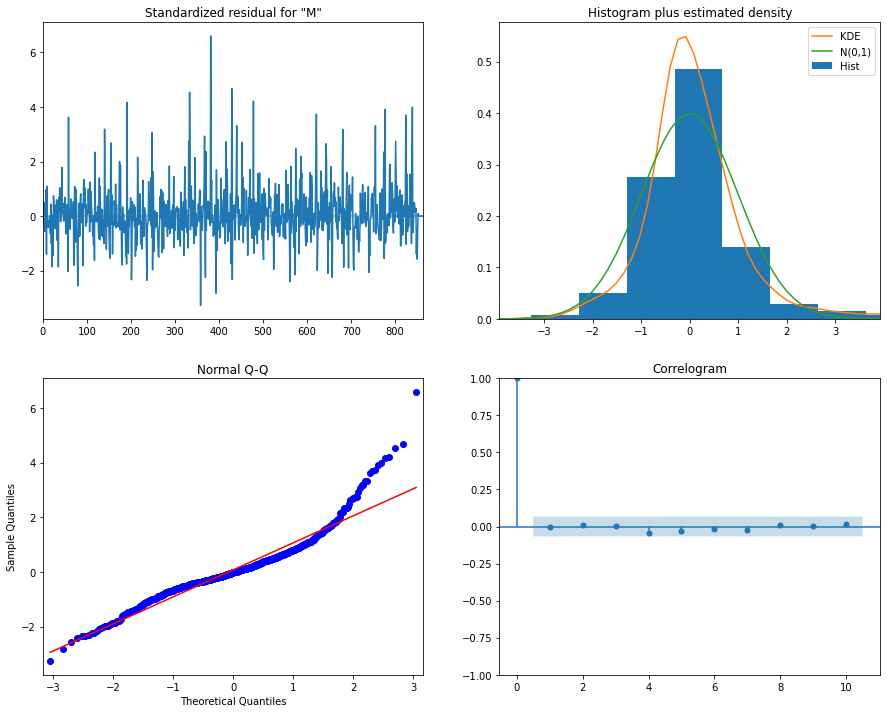

In [111]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [143]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.conf_int()

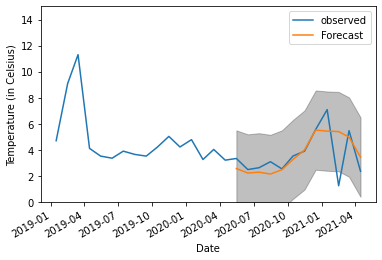

In [144]:
ax = one_step_df.Maxactual['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-0,15])
plt.legend()
plt.show()

In [136]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=False)
pred_ci = pred.predicted_mean
mse = MSE(test, pred_ci, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.92


In [138]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

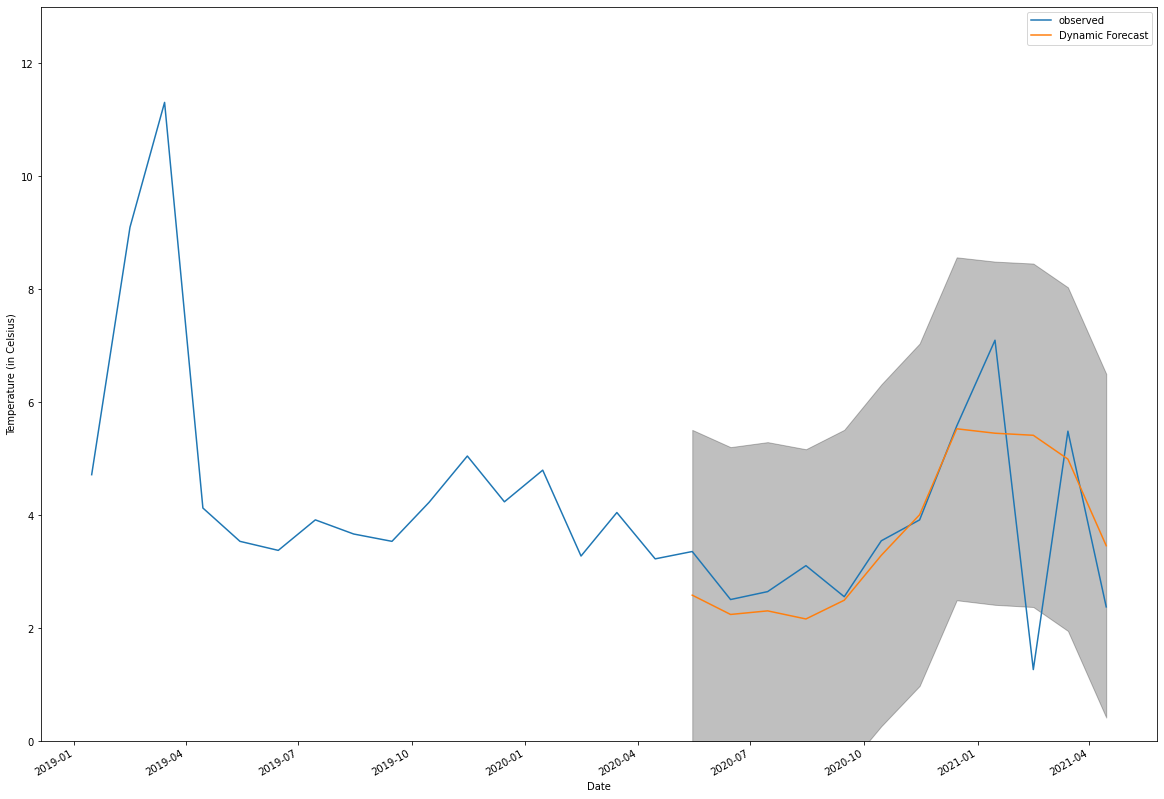

In [140]:
ax = one_step_df1.Maxactual['2019':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,13])
plt.legend()
plt.show()

In [141]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-05-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.predicted_mean
mse = MSE(test, pred_ci, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.92


Last Try:

In [166]:
train = one_step_df1[:779]

In [167]:
test = one_step_df1[779:]

In [181]:
len(test)

112

In [168]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [169]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
metric_aic_dict = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            metric_aic_dict.update({(param,param_seasonal):results.aic})
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4115.366755425191
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3683.251572989266
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3287.875503026198
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2777.91208789161
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3218.4810218819266
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2829.2814634746746
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2971.581574202585
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2783.9327323353873
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3688.3626776912506
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3473.701656989212
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3278.662084756696
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2757.2557371109315
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3198.893135475437
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2810.974423064057
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2952.203316453647
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2762.536238917371
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3272.073995825811
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3223.2

In [170]:
{k: v for k, v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

{((1, 0, 1), (0, 1, 1, 12)): 2738.4532816751935,
 ((1, 0, 1), (1, 1, 1, 12)): 2745.074692710461,
 ((1, 1, 1), (0, 1, 1, 12)): 2746.21980076584,
 ((0, 1, 1), (0, 1, 1, 12)): 2755.6185363939817,
 ((0, 0, 1), (0, 1, 1, 12)): 2757.2557371109315,
 ((1, 1, 1), (1, 1, 1, 12)): 2758.263396608934,
 ((1, 0, 0), (0, 1, 1, 12)): 2758.918297014352,
 ((0, 0, 1), (1, 1, 1, 12)): 2762.536238917371,
 ((1, 0, 0), (1, 1, 1, 12)): 2764.596296896053,
 ((0, 1, 1), (1, 1, 1, 12)): 2767.9840020766615,
 ((0, 0, 0), (0, 1, 1, 12)): 2777.91208789161,
 ((0, 0, 0), (1, 1, 1, 12)): 2783.9327323353873,
 ((1, 0, 1), (1, 0, 1, 12)): 2793.6691752334223,
 ((1, 1, 1), (1, 0, 1, 12)): 2803.883323772913,
 ((1, 0, 0), (1, 0, 1, 12)): 2809.8553101769894,
 ((0, 0, 1), (1, 0, 1, 12)): 2810.974423064057,
 ((0, 1, 1), (1, 0, 1, 12)): 2813.59277762484,
 ((0, 0, 0), (1, 0, 1, 12)): 2829.2814634746746,
 ((1, 1, 1), (1, 0, 0, 12)): 2931.381174311896,
 ((1, 0, 1), (1, 1, 0, 12)): 2931.7802002899753,
 ((1, 1, 0), (0, 1, 1, 12)): 2934.

In [171]:
import statsmodels.api as sm
#SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3058.5411445042273
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7659      0.102      7.544      0.000       0.567       0.965
ma.L1         -0.6162      0.117     -5.246      0.000      -0.846      -0.386
ma.S.L12      -0.9145      0.014    -66.437      0.000      -0.942      -0.888
sigma2         2.1574      0.058     36.880      0.000       2.043       2.272


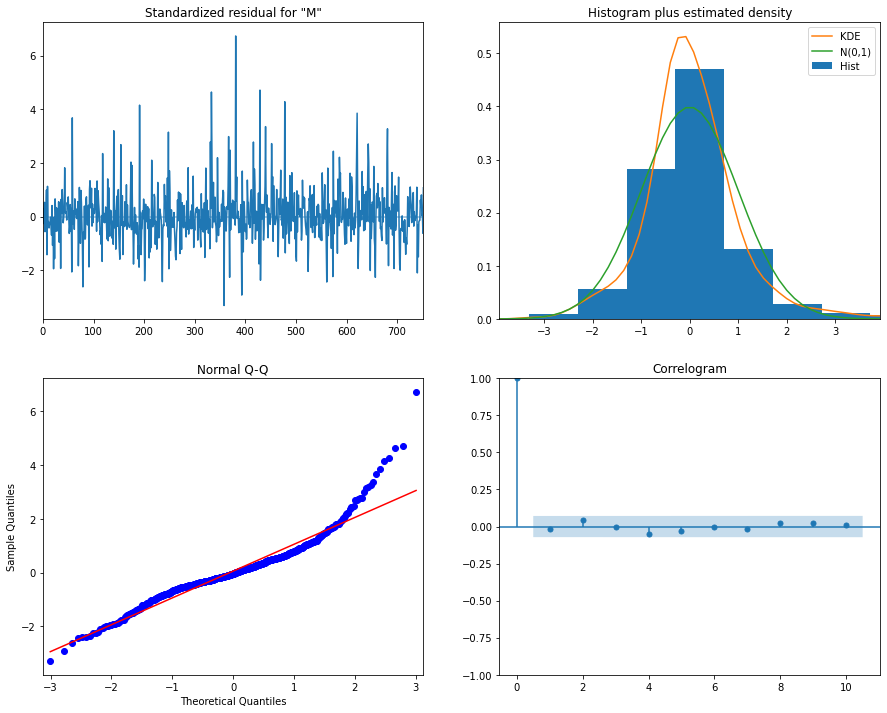

In [178]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [194]:
import pmdarima as pm
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=24,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=7.70 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=3166.857, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=2949.634, Time=1.62 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=3164.944, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=3131.317, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=2902.544, Time=4.15 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=20.47 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.19 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=2922.132, Time=5.62 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=2891.064, Time=9.23 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=2940.111, Time=3.30 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=31.61 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=17.23 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=28

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  779
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 24)   Log Likelihood               -1439.605
Date:                            Thu, 27 May 2021   AIC                           2889.211
Time:                                    21:06:45   BIC                           2912.344
Sample:                                         0   HQIC                          2898.122
                                            - 779                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1484      0.028      5.227      0.000       0.093       0.204
ar.L2          0.1333      0.032      4.175      0.000       0.071       0.196
ar.S.L24      -0.5907      0.028    -21.248      0.000      -0.645      -0.536
ar.S.L48      -0.2624      0.028     -9.246      0.000      -0.318      -0.207
sigma2         2.6200      0.091     28.935      0.000       2.443       2.797
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               256.30
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.57
Prob(H) (two-sided):                  0.89   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

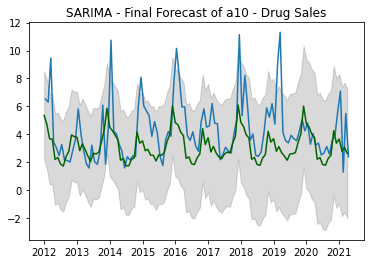

In [195]:
# Forecast
n_periods = 112
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(test)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

For temp MIN:

In [12]:
predicted_df = df2["timeMin"].to_frame().shift(1).rename(columns = {"timeMin": "Minpredicted" })
actual_df = df2["timeMin"].to_frame().rename(columns = {"timeMin": "Minactual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)

,Minactual,Minpredicted
time,,
1947-02-15,-3.48,-6.66
1947-03-15,-3.64,-3.48
1947-04-15,-1.90,-3.64
1947-05-15,-2.55,-1.90
1947-06-15,-1.95,-2.55
1947-07-15,-1.55,-1.95
1947-08-15,-2.24,-1.55
1947-09-15,-1.47,-2.24
1947-10-15,-0.43,-1.47


In [13]:
# Calculate the RMSE
temp_pred_err = MSE(one_step_df.Minactual, one_step_df.Minpredicted, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 1.9519756


In [201]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.Minactual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4239.627033879555
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3818.617150539454
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:3644.2396328707027
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3625.836640909553
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3121.3022018829615
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:3085.7378258164968
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:4475.822826260362
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:3585.9585343717213
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3504.22412758277
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3139.2320891202835
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:3094.477485150921
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3425.4787648328866
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3131.5357783334885
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:3075.7801541463095
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:4041.1257393498213
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:3439.153988191263
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:3117.087826282072
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:33

In [14]:
import statsmodels.api as sm
#SARIMA(1, 1, 1)x(1, 1, 2, 12)12 3052 AIC BEST MODEL
# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.Minactual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

C:\Users\catti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\catti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\Users\catti\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


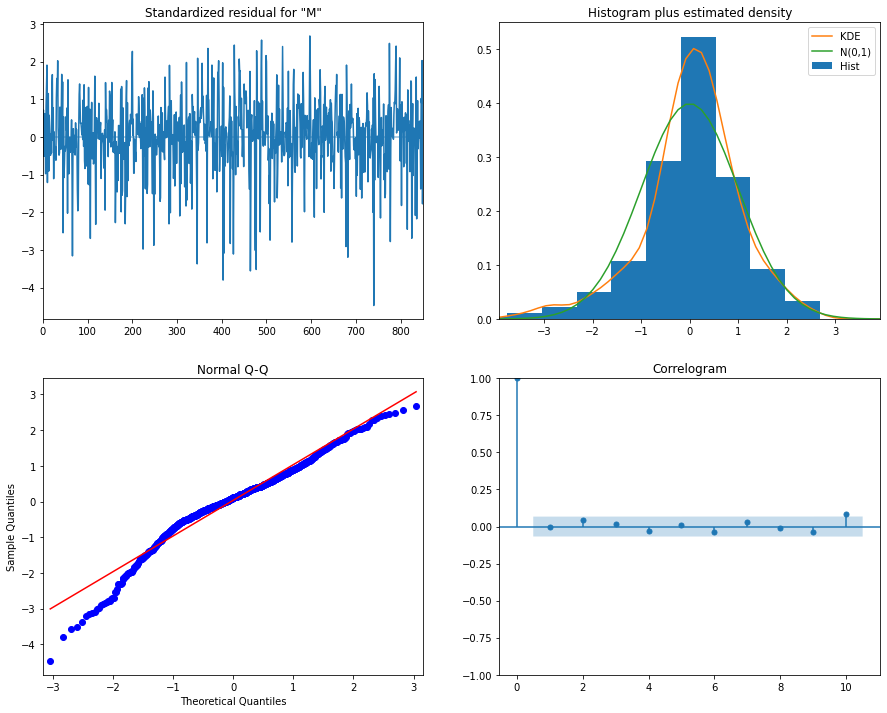

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=False)
pred_ci = pred.conf_int()

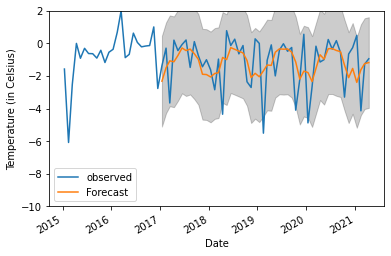

In [17]:
ax = one_step_df.Minactual['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-10,2])
plt.legend()
plt.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.Minactual['2017-01-15':]
print(y_forecasted.shape)
print(y_truth.shape)
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(52,)
(52,)
The Mean Squared Error of our forecasts is 2.11


In [19]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

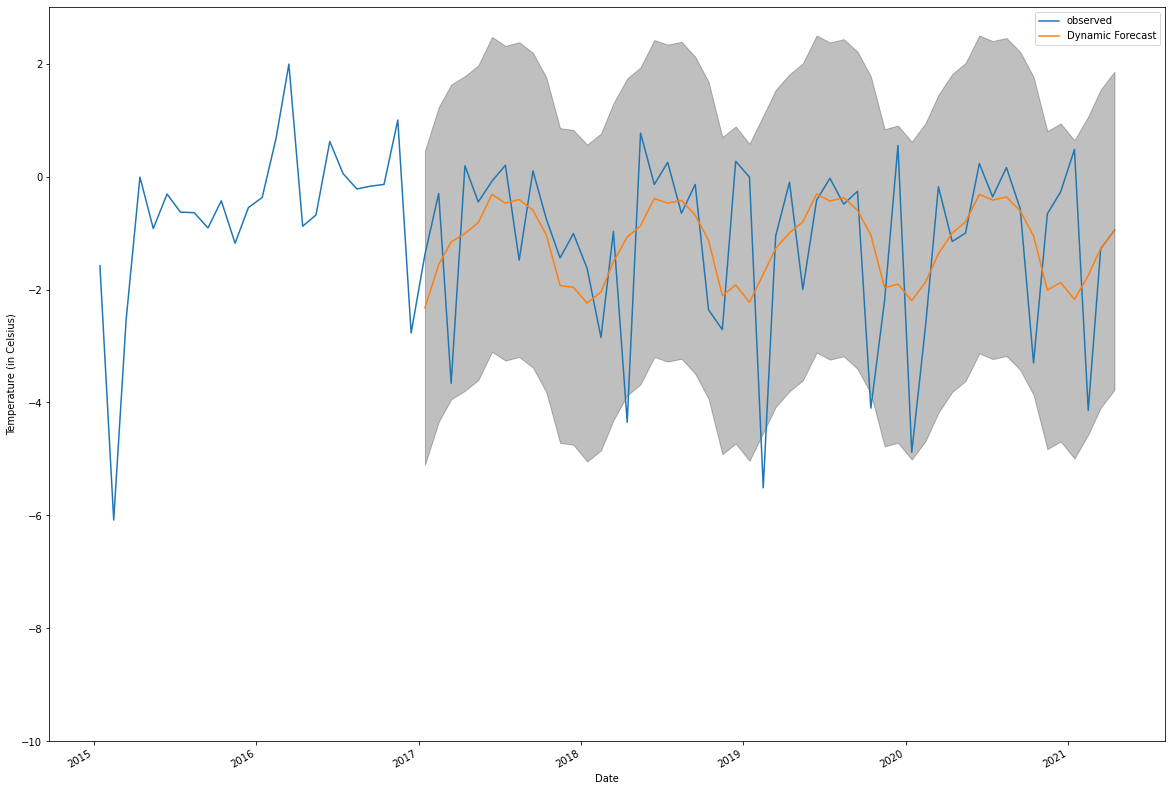

In [20]:
ax = one_step_df.Minactual['2015':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-10,3])
plt.legend()
plt.show()